### Import Library dan Dataset

In [ ]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


import torch
from torch.utils.data import DataLoader
from torch.optim import Adam
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
)
from datasets import Dataset, DatasetDict
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm

/home/sorr/anaconda3/envs/skripsi/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('./data/data_cleaned.csv')
df.head()

,Tweet,Label
0,aib bodoh benar sebelum kata aib itu muncul te...,Marah
1,lo takut enggak sih anjir selasa depan anjir t...,Takut
2,feb hari ini flight balik jakarta sedih degdeg...,Sedih
3,gajian saja belum sudah ada yang mengomong nan...,Sedih
4,selamat pagi juga pak suryo salam sehat penuh ...,Gembira


In [3]:
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name())

2.8.0+cu129
True
0
NVIDIA GeForce RTX 5070


### Menyamakan Seed

In [4]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
set_seed(42)

### Persiapan Dataset

In [5]:
label_encoder = LabelEncoder()
df["LabelEncoded"] = label_encoder.fit_transform(df["Label"])
num_labels = len(label_encoder.classes_)

id2label = {i: lab for i, lab in enumerate(label_encoder.classes_)}
label2id = {lab: i for i, lab in id2label.items()}

In [6]:
# Splitting Dataset
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df["Tweet"], df["LabelEncoded"], test_size=0.3, stratify=df["LabelEncoded"], random_state=42
)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
)

In [7]:
# Konversi ke Dataset Hugging Face
dataset = DatasetDict({
    "train": Dataset.from_dict(
        {"text": list(train_texts), 
         "labels": list(train_labels)}),
    "validation": Dataset.from_dict(
        {"text": list(val_texts), 
         "labels": list(val_labels)}),
    "test": Dataset.from_dict(
        {"text": list(test_texts), 
         "labels": list(test_labels)}),
})

dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 3466
    })
    validation: Dataset({
        features: ['text', 'labels'],
        num_rows: 743
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 743
    })
})

### Tokenisasi

In [8]:
# Mengambil Tokenizer dari model IndoBERT
MODEL_NAME = "indobenchmark/indobert-base-p1"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)


def tokenize_function(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=128
    )


tokenized_dataset = dataset.map(
    tokenize_function, 
    batched=True, 
    remove_columns=["text"])

tokenized_dataset.set_format(
    "torch", 
    columns=["input_ids", 
            "attention_mask", 
            "labels"])

Map: 100%|██████████| 743/743 [00:00<00:00, 28408.61 examples/s]


In [9]:
# Data Batching dan Batch Preparation
data_collator = DataCollatorWithPadding(
    tokenizer=tokenizer, return_tensors="pt")

train_loader = DataLoader(
    tokenized_dataset["train"], batch_size=16, shuffle=True, collate_fn=data_collator)
val_loader = DataLoader(
    tokenized_dataset["validation"], batch_size=16, collate_fn=data_collator)
test_loader = DataLoader(
    tokenized_dataset["test"], batch_size=16, collate_fn=data_collator)

### Fine-Tuning

In [10]:
# Menyiapkan Model untuk Fine-Tuning
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(label2id)
).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
optimizer = Adam(model.parameters(), lr=1e-5, weight_decay=0.01)

num_epochs = 4
loss_fn = torch.nn.CrossEntropyLoss()

In [12]:
# Training Loop
history = {
    "train_loss": [], "val_loss": [],
    "train_acc":  [], "val_acc":  [],
}

for epoch in range(num_epochs):
    # ---- Training ----
    model.train()
    train_loss = 0.0
    train_preds, train_labels_all = [], []

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training")
    for batch in pbar:
        batch = {k: v.to(device) for k, v in batch.items()}

        optimizer.zero_grad()
        outputs = model(**batch)
        loss = loss_fn(outputs.logits, batch["labels"])
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
        labels = batch["labels"].cpu().numpy()
        train_preds.extend(preds)
        train_labels_all.extend(labels)

        pbar.set_postfix({"loss": f"{loss.item():.4f}"})

    avg_train_loss = train_loss / len(train_loader)
    train_acc = accuracy_score(train_labels_all, train_preds)

    # ---- Validation ----
    model.eval()
    val_loss = 0.0
    val_preds, val_labels_all = [], []
    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = loss_fn(outputs.logits, batch["labels"])
            val_loss += loss.item()

            preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
            labels = batch["labels"].cpu().numpy()
            val_preds.extend(preds)
            val_labels_all.extend(labels)

    avg_val_loss = val_loss / len(val_loader)
    val_acc = accuracy_score(val_labels_all, val_preds)

    # simpan history
    history["train_loss"].append(avg_train_loss)
    history["val_loss"].append(avg_val_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)

    # tampilkan ringkasan per-epoch
    print(
        f"loss: {avg_train_loss:.4f} - acc: {train_acc:.4f} - "
        f"val_loss: {avg_val_loss:.4f} - val_acc: {val_acc:.4f}"
    )

Epoch 1/4 - Training: 100%|██████████| 217/217 [00:21<00:00, 10.07it/s, loss=0.5135]


loss: 0.8109 - acc: 0.7178 - val_loss: 0.5072 - val_acc: 0.8371


Epoch 2/4 - Training: 100%|██████████| 217/217 [00:21<00:00, 10.04it/s, loss=0.3333]


loss: 0.3841 - acc: 0.8725 - val_loss: 0.5423 - val_acc: 0.8237


Epoch 3/4 - Training: 100%|██████████| 217/217 [00:21<00:00, 10.06it/s, loss=0.0915]


loss: 0.2655 - acc: 0.9146 - val_loss: 0.5272 - val_acc: 0.8398


Epoch 4/4 - Training: 100%|██████████| 217/217 [00:21<00:00,  9.99it/s, loss=0.1911]


loss: 0.1787 - acc: 0.9458 - val_loss: 0.5636 - val_acc: 0.8425


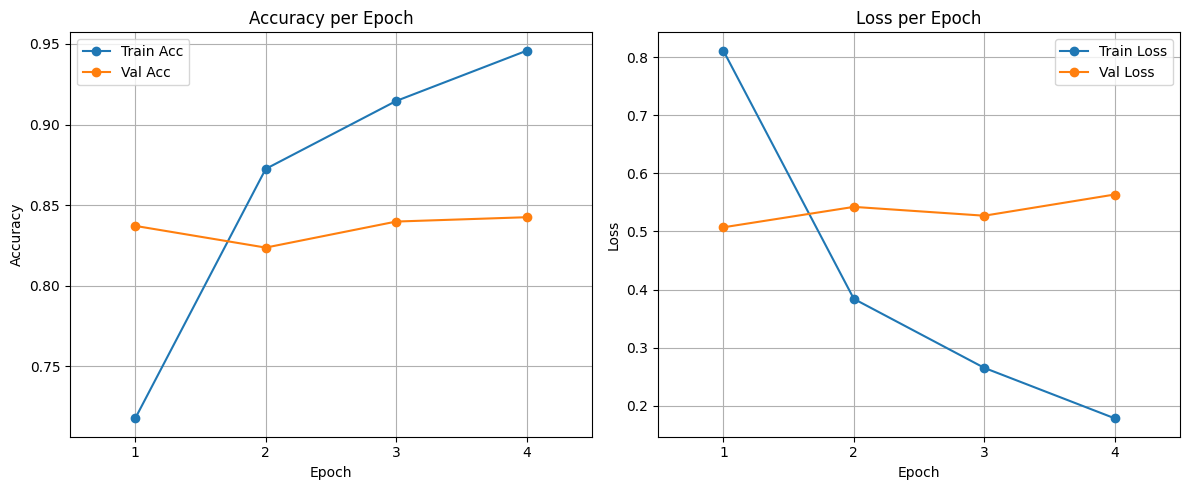

In [13]:
plt.figure(figsize=(12, 5))
epochs = range(1, len(history["train_acc"]) + 1)

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, history["train_acc"], marker='o', label="Train Acc")
plt.plot(epochs, history["val_acc"], marker='o', label="Val Acc")
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.xticks(epochs)
plt.xlim(0.5, len(epochs) + 0.5)
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, history["train_loss"], marker='o', label="Train Loss")
plt.plot(epochs, history["val_loss"], marker='o', label="Val Loss")
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks(epochs)
plt.xlim(0.5, len(epochs) + 0.5)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Evaluasi

In [14]:
# Evaluasi
model.eval()
train_preds, train_labels_all = [], []
with torch.no_grad():
    for batch in train_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
        labels = batch["labels"].cpu().numpy()
        train_preds.extend(preds)
        train_labels_all.extend(labels)

train_acc = accuracy_score(train_labels_all, train_preds)

# Evaluasi pada TEST SET
test_preds, test_labels_all = [], []
with torch.no_grad():
    for batch in test_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
        labels = batch["labels"].cpu().numpy()
        test_preds.extend(preds)
        test_labels_all.extend(labels)

test_acc = accuracy_score(test_labels_all, test_preds)

print(f"Akurasi Training Set: {train_acc:.4f}")
print(f"Akurasi Test Set: {test_acc:.4f}")

Akurasi Training Set: 0.9714
Akurasi Test Set: 0.8560


In [15]:
# Classification Reports
print("\nClassification Report:")
print(classification_report(test_labels_all,
      test_preds, target_names=label2id.keys(), digits=4))


Classification Report:
              precision    recall  f1-score   support

       Cinta     0.8333    0.7965    0.8145       113
     Gembira     0.8199    0.9202    0.8672       188
       Marah     0.9000    0.8025    0.8485       157
       Sedih     0.8630    0.8456    0.8542       149
       Takut     0.8768    0.8897    0.8832       136

    accuracy                         0.8560       743
   macro avg     0.8586    0.8509    0.8535       743
weighted avg     0.8579    0.8560    0.8556       743



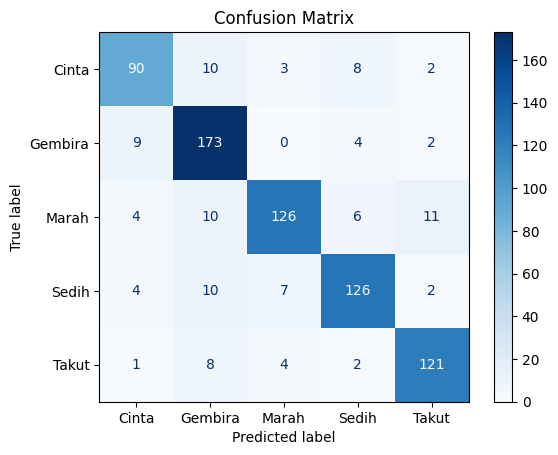

In [16]:
# Confusion Matrix
cm = confusion_matrix(test_labels_all, test_preds)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=label2id.keys())
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()